In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ase.io import read

In [2]:
# 读取轨迹文件
traj = read('XDATCAR', index=':')

In [3]:
# 获取初始结构信息
first_frame = traj[0]

In [4]:
# 确定铜表面原子（初始结构选择）
cu_indices = [i for i, atom in enumerate(first_frame) if atom.symbol == 'Cu']
cu_positions = first_frame.get_positions()[cu_indices]
sorted_indices = np.argsort(-cu_positions[:, 2])
surface_cu_indices = [cu_indices[i] for i in sorted_indices[:16]]

In [5]:
# 检测钾原子数量
k_indices = [i for i, atom in enumerate(first_frame) if atom.symbol == 'K']
k_count = len(k_indices)
if k_count not in [1, 2]:
    raise ValueError(f"检测到{k_count}个钾原子，仅支持1或2个钾原子的情况")

In [6]:
# 初始化存储结构
time_steps = []
#time_steps_ps = [step / 1000 for step in time_steps]  # 添加单位转换
#time_steps_ps = np.arange(len(traj)) * time_steps / 1000  # 转换为ps
distances = [[] for _ in range(k_count)]  # 根据钾原子数量创建存储列表

In [7]:
# 主处理循环
for step, frame in enumerate(traj):
    # 获取表面铜原子坐标
    surf_pos = frame.get_positions()[surface_cu_indices]
    
    # 计算表面平面参数
    centroid = np.mean(surf_pos, axis=0)
    cov_matrix = np.cov((surf_pos - centroid).T)
    _, eigvecs = np.linalg.eigh(cov_matrix)
    normal = eigvecs[:, 0] / np.linalg.norm(eigvecs[:, 0])
    
    # 获取钾原子坐标并计算距离
    k_positions = [frame[i].position for i in k_indices]
    
    time_steps.append(step)
    for i, pos in enumerate(k_positions):
        distance = abs(np.dot(pos - centroid, normal))
        distances[i].append(distance)

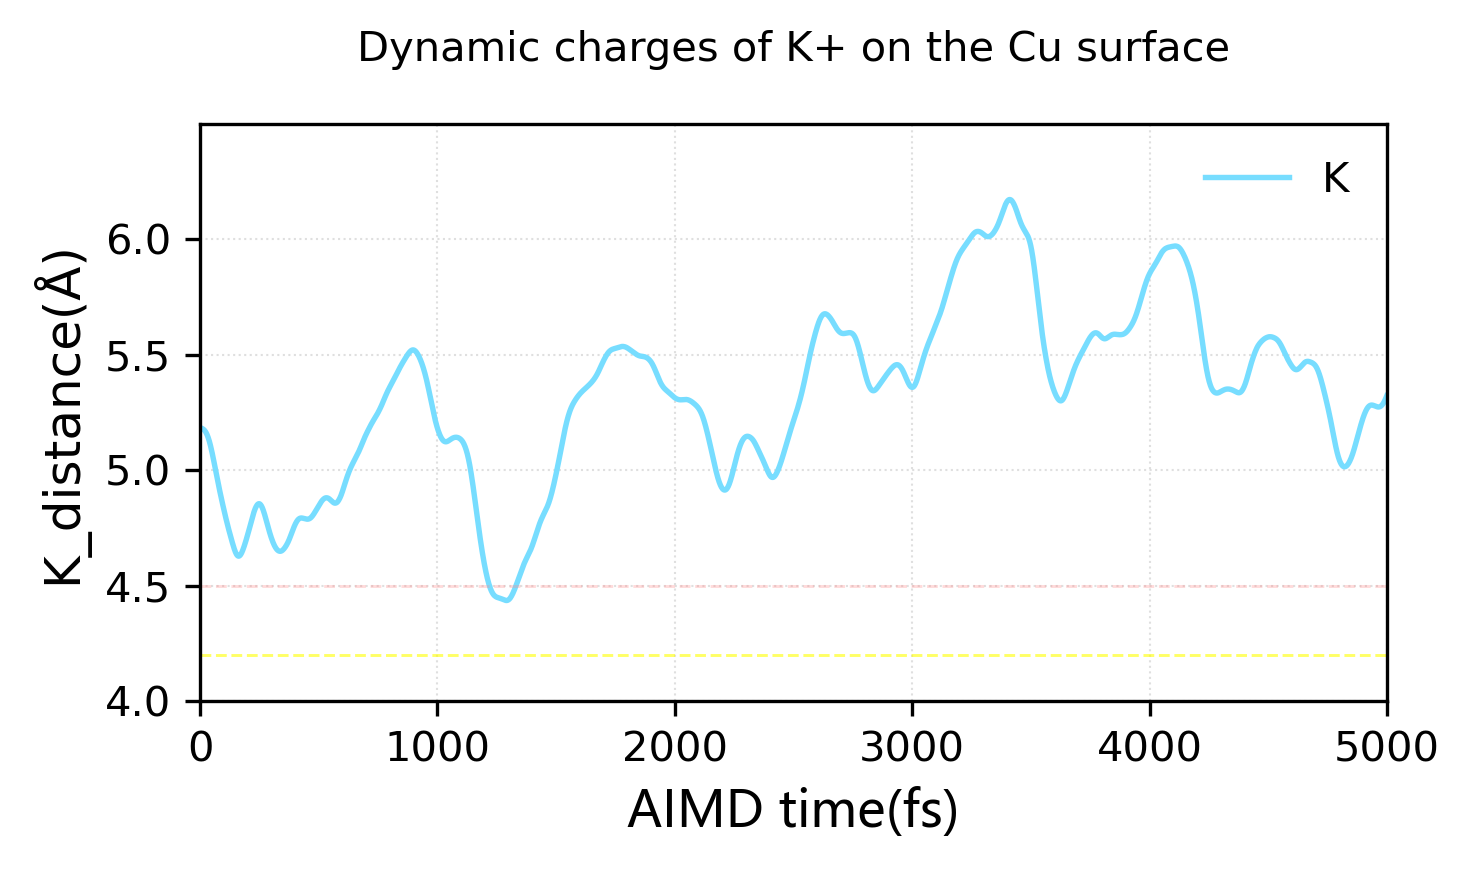

In [11]:
# 绘图配置
plt.figure(figsize=(5, 3), dpi = 300)
plt.xlim(0, 5000)   #调整x轴的刻度
plt.ylim(4, 6.5)
colors = ['#77DDFF', '#FFAA33']  # 定义颜色
labels = ['K1', 'K2'] if k_count == 2 else ['K']
for i in range(k_count):
    plt.plot(time_steps, distances[i], 
             color=colors[i], 
             label=labels[i],
             linewidth = 1.3,
             alpha = 1)
plt.axhline(y = 4.2, color = '#FFFF00', linestyle = '--', linewidth = 0.7, alpha = 0.6)   #添加一条虚线
plt.axhline(y = 4.5, color = '#FF8888', linestyle = '--', linewidth = 0.7, alpha = 0.3)
#ax.spines['all'].set_linewidth(1)   #设置框线线宽left，right，top可以分别设置
#添加图例和网格线
plt.legend(loc = 'best', frameon = False, fontsize = 10)   #frameon = False不显示图例边框
plt.grid(True, linestyle = ':', linewidth = 0.5, alpha = 0.4)
#调整x轴上的刻度线
y_ticks = np.arange(4, 6.5, 0.5)
plt.yticks(y_ticks)
#设置标签
plt.xlabel('AIMD time(fs)', fontsize = 12, fontfamily='Microsoft YaHei')   #fontfamily设置字体
plt.ylabel('K_distance(Å)', fontsize = 12)
plt.plot(distances, 'r-', lw = 1)
#添加标题
plt.title(f'Dynamic charges of K+ on the Cu surface', fontsize = 10, pad = 15)

plt.tight_layout()  #调整子图的位置，使得子图之间的空间更加合理，避免标签、标题或刻度标签之间的重叠
plt.savefig('k1-Cu-AIMD.png', dpi = 600, bbox_inches = 'tight')
plt.show()